<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Ingest" data-toc-modified-id="Data-Ingest-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Ingest</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Growth" data-toc-modified-id="Growth-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Growth</a></span></li><li><span><a href="#Changepoints" data-toc-modified-id="Changepoints-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Changepoints</a></span></li><li><span><a href="#Holidays" data-toc-modified-id="Holidays-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Holidays</a></span></li></ul></div>

# Data Ingest

Link [here](https://facebookincubator.github.io/prophet/docs/quick_start.html)

In [73]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
import datetime as dt
from fbprophet import Prophet
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='pearl')
tls.set_credentials_file(
    username=os.environ.get('PLOTLY_USERNAME'),
    api_key=os.environ.get('PLOTLY_APIKEY'))
import matplotlib as plt
%matplotlib inline

In [153]:
train_csv = 'data/nymex_train.csv'
train_df = pd.read_csv(train_csv)
train_df.head()

,Day,New York Harbor No. 2 Heating Oil Future Contract 1 $/gal
0,06/20/2017,1.395
1,06/19/2017,1.411
2,06/16/2017,1.427
3,06/15/2017,1.415
4,06/14/2017,1.410


In [154]:
test_csv = 'data/nymex_test.csv'
test_df = pd.read_csv(test_csv)
test_df.head()

,Day,New York Harbor No. 2 Heating Oil Future Contract 1 Dollars per Gallon
0,02/21/2018,1.932
1,02/20/2018,1.928
2,02/19/2018,1.910
3,02/16/2018,1.910
4,02/15/2018,1.892


In [155]:
# clean-up
def process_df(df):

    # nymex futures
    date_field = 'date_id'
    data_field = 'no2_ho'

    # clean-up col names
    df.columns = [c.lower() for c in df.columns]
    df.columns = [date_field, data_field]

    # set ds and y fields
    df['ds'] = pd.to_datetime(df[date_field])
    df['y'] = np.log(df[data_field])

    # file is in reverse time order
    df = df[['ds', 'y']]
    df = df.sort_values(by=['ds'], ascending=True)

    # print limits
    print(df.ds.min(), df.ds.max())

    return df

In [156]:
# dfs list
train_df = process_df(train_df)
test_df = process_df(test_df)

1980-01-02 00:00:00 2017-06-20 00:00:00
1980-01-02 00:00:00 2018-02-21 00:00:00


In [158]:
today = train_df.ds.max()
lookback = today - dt.timedelta(days=2*365)
train_df = train_df[(train_df.ds >= lookback)]

In [159]:
# remove overlap
test_df = test_df[(test_df.ds >= train_df.ds.max())]
train_df = train_df[(train_df.ds <= test_df.ds.min())]

In [160]:
trace0 = go.Scatter(x=train_df.ds, y=train_df.y, mode='lines', name='train')
trace1 = go.Scatter(x=test_df.ds, y=test_df.y, mode='lines', name='test')
data = [trace0, trace1]
py.iplot(data)

# Modeling

In [161]:
m = Prophet(yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=0.75)
m.fit(train_df);

/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [206]:
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

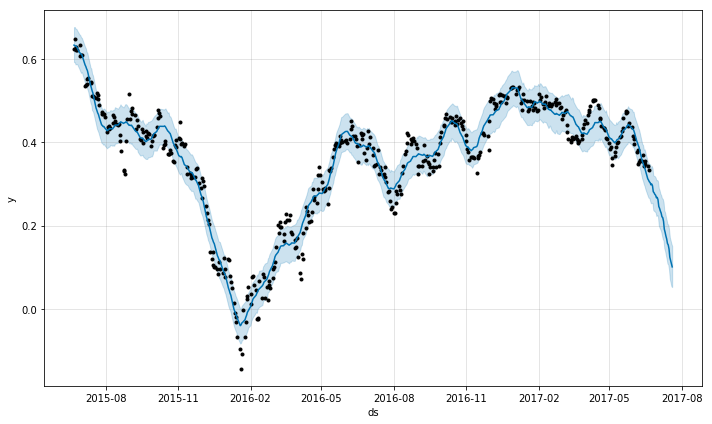

In [207]:
m.plot(forecast);

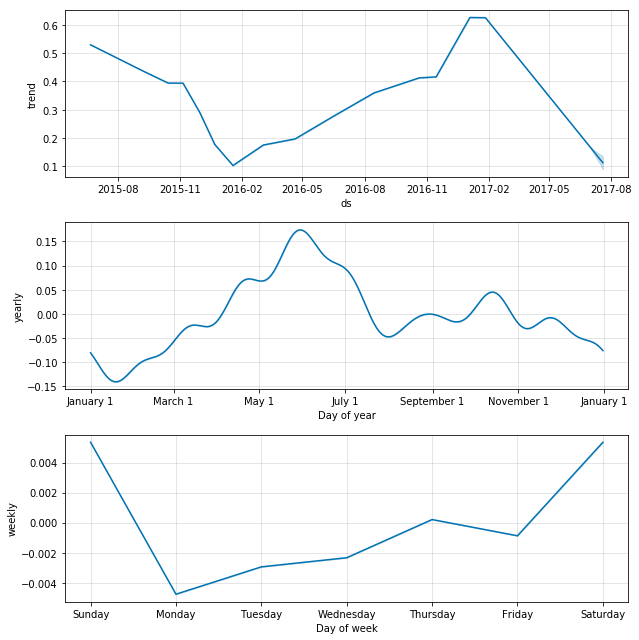

In [208]:
m.plot_components(forecast);

In [209]:
trace0 = go.Scatter(x=forecast.ds, y=forecast.yhat, mode='lines', name='forecast')
trace1 = go.Scatter(x=train_df.ds, y=train_df.y, mode='lines', name='train')
trace2 = go.Scatter(x=test_df.ds, y=test_df.y, mode='lines', name='test')
data = [trace0, trace1, trace2]
py.iplot(data)

# Growth

Link [here](https://facebookincubator.github.io/prophet/docs/forecasting_growth.html)

In [210]:
train_df['cap'] = 2

In [214]:
m = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.75)
m.fit(train_df);

/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [222]:
future = m.make_future_dataframe(periods=30)
future['cap'] = 2
forecast = m.predict(future)

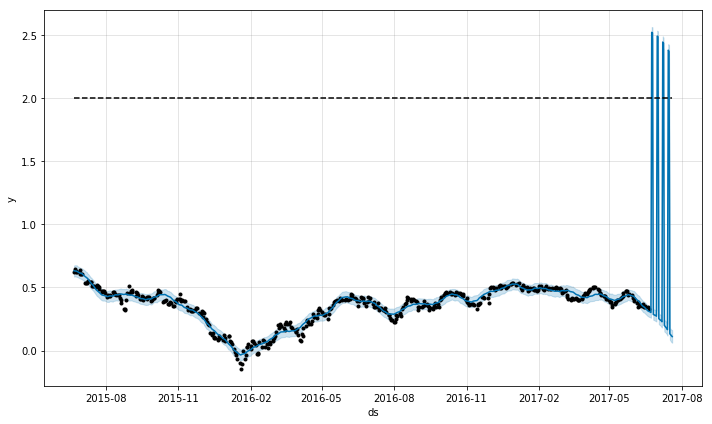

In [223]:
m.plot(forecast);

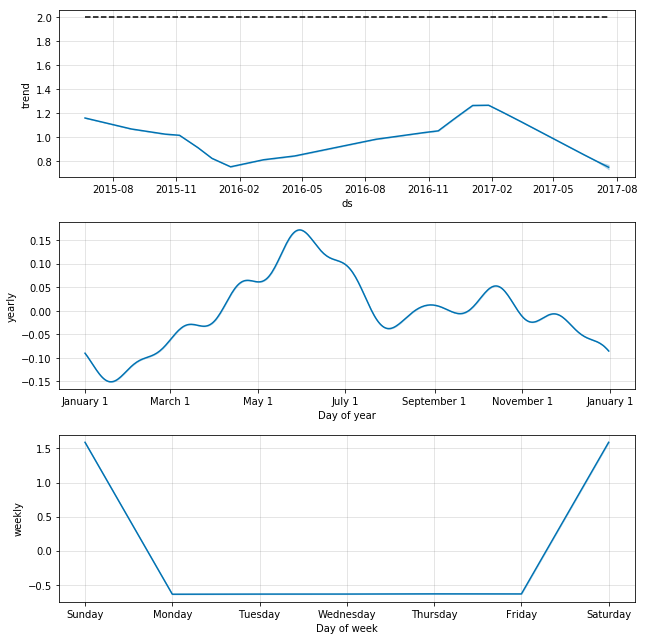

In [224]:
m.plot_components(forecast);

# Changepoints

Link [here](https://facebookincubator.github.io/prophet/docs/trend_changepoints.html)

In [ ]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df).predict(future)
m.plot(forecast);

In [ ]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(df).predict(future)
m.plot(forecast)

In [ ]:
m = Prophet(changepoints=['2011-10-01'])
forecast = m.fit(df).predict(future)
m.plot(forecast);

# Holidays

Link [here](https://facebookincubator.github.io/prophet/docs/holiday_effects.html)

In [ ]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [ ]:
m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)

In [ ]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

In [ ]:
m.plot_components(forecast)

In [ ]:
m = Prophet(holidays=holidays, holidays_prior_scale=1).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

In [ ]:
m.plot(forecast)